In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
# from dance_evaluation import *
import matplotlib.pyplot as plt
# from calculate_score import *
from collections import defaultdict

def load_pickle(filepath):
    with open(filepath, "rb") as f:
        json_data = pickle.load(f)
    return json_data

def save_to_pickle(filepath, data):
    # filepath = os.path.join(savepath, filename)
    with open(filepath, "wb") as f:
        pickle.dump(data, f)

In [2]:

def compute_dts(
    ref_bpm,
    estimated_bpm,
    tau=0.06,
    mode="one"
):
    """
    Continuous Dance-Tempo Score (DTS), with support for
    either single estimates (mode="one") or multiple
    candidates per frame (mode="many").

    Parameters
    ----------
    ref_bpm : array-like, shape (n,)
        Ground-truth musical tempo in BPM.
    estimated_bpm : 
        If mode="one": array-like, shape (n,)
        If mode="many": iterable of length-n, each element
                        is an iterable of candidate BPMs.
    tau : float, optional
        Tolerance in octaves (0.06 ≈ 4 %).
    mode : {"one", "many"}
        “one”: treat `estimated_bpm` as a flat sequence.
        “many”: pick, for each i, the candidate closest to ref_bpm[i].

    Returns
    -------
    dts : ndarray, shape (n,)
        Scores in [0, 1] (1 = perfect, 0 = miss ≥ τ octaves away).
    e : ndarray, shape (n,)
        Raw octave errors log₂(estimate/ref).
    d : ndarray, shape (n,)
        Wrapped distance to {-1, 0, +1} before clipping.
    """
    ref_bpm = np.asarray(ref_bpm, dtype=float)

    # select a single estimate per index if needed
    if mode == "many":
        # estimated_bpm is e.g. [(b1, b2,...), (c1, c2,...), ...]
        chosen = np.array([
            min(cands, key=lambda b: abs(b - ref_bpm[i]))
            for i, cands in enumerate(estimated_bpm)
        ], dtype=float)
    elif mode == "one":
        chosen = np.asarray(estimated_bpm, dtype=float)
    else:
        raise ValueError(f"Unknown mode: {mode!r}. Use 'one' or 'many'.")

    # now compute the DTS exactly as before
    e = np.log2(chosen / ref_bpm)
    # distance from nearest of -1, 0, +1
    d = np.abs(e[:, None] - np.array([-1.0, 0.0, 1.0])).min(axis=1)
    # clip by tolerance and convert to score
    d_clip = np.minimum(d, tau)
    dts    = 1.0 - d_clip / tau

    accuracy = (dts > 0.0).mean() * 100
    
    # hits ----------------------------------------------------------
    hit_mask = dts > 0.0          # inside ±tau band
    hit_idx = np.nonzero(hit_mask)[0]
    ref_hit_bpm = ref_bpm[hit_idx]
    
    return dts, e, d, accuracy


In [8]:
from collections import defaultdict

# helper to compute accuracy and fill a dictionary
def collect_accuracies(folder, metric_tag):
    acc = {}
    for fname in os.listdir(folder):
        tag = fname.split("_zero_uni")[0]
        data = load_pickle(f"{folder}/{fname}")
        ref  = data["music_tempo"].to_numpy()
        _, _, _, accuracy = compute_dts(ref, data["bpm_median"].to_numpy(),
                                        tau=0.10, mode="one")
        if tag in friendly:
            acc[friendly[tag] ] = round(accuracy, 2)
    return acc


friendly = {
    "both_hand_y":  "both_hand_y",
    "both_foot_y":  "both_foot_y",
}

a, b = 25, 140
root = "/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result"

tdir_names = os.listdir(root)
tempo_ranges = [tuple(map(int, name.split("_")[1:])) for name in tdir_names]
# tempo_ranges = sorted(tempo_ranges, key=lambda x: x[0]) # sort by lower bound
# tempo_labels = [f"{a}-{b}" for a, b in tempo_ranges]

tempo_ranges = [
    (30, 120),
    (30, 140),
    (30, 180),
    (30, 240),
    (60, 120),
    (60, 140),
    (80, 140),
    (80, 200),
]

tempo_labels = ['30-120',    '30-140',    '30-180',    '30-240',    
                '60-120',    '60-140',    '80-140',    '80-200',]
acc_hand = []
acc_foot = []


for a, b in tempo_ranges:
    pth_pos = f"{root}/tempo_{a}_{b}/pos"
    accuracy_dict_pos = collect_accuracies(pth_pos, "pos")
    
    # print(accuracy_dict_pos)
    # pull accuracies for hand and foot
    acc_hand.append(accuracy_dict_pos.get("both_hand_y", None))
    acc_foot.append(accuracy_dict_pos.get("both_foot_y", None))


## plotting




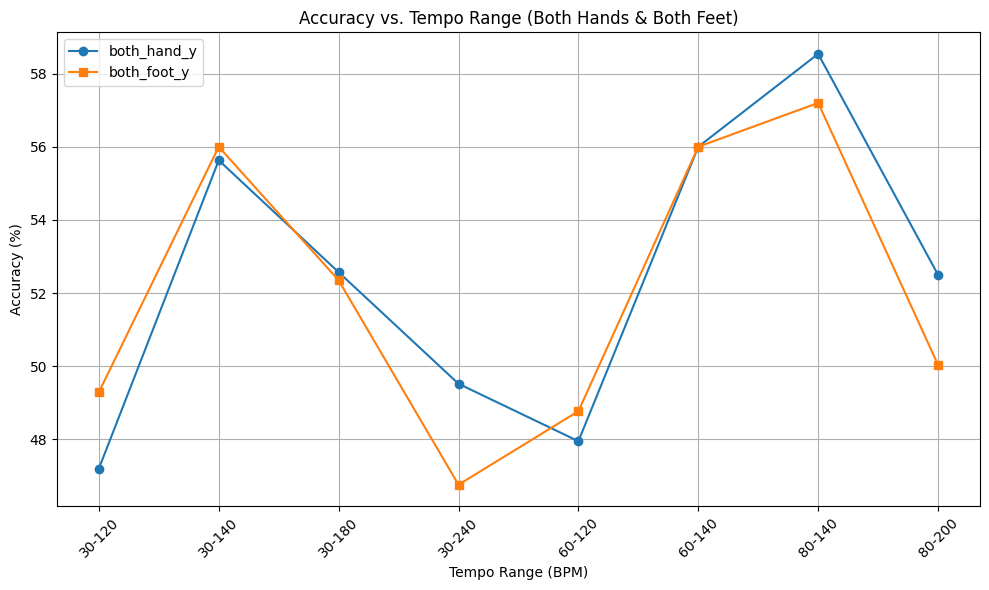

In [9]:
# plot
plt.figure(figsize=(10, 6))
plt.plot(tempo_labels, acc_hand, marker='o', label=friendly["both_hand_y"])
plt.plot(tempo_labels, acc_foot, marker='s', label=friendly["both_foot_y"])

plt.xticks(rotation=45)
plt.xlabel("Tempo Range (BPM)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Tempo Range (Both Hands & Both Feet)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()